In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns

np.random.seed(42)

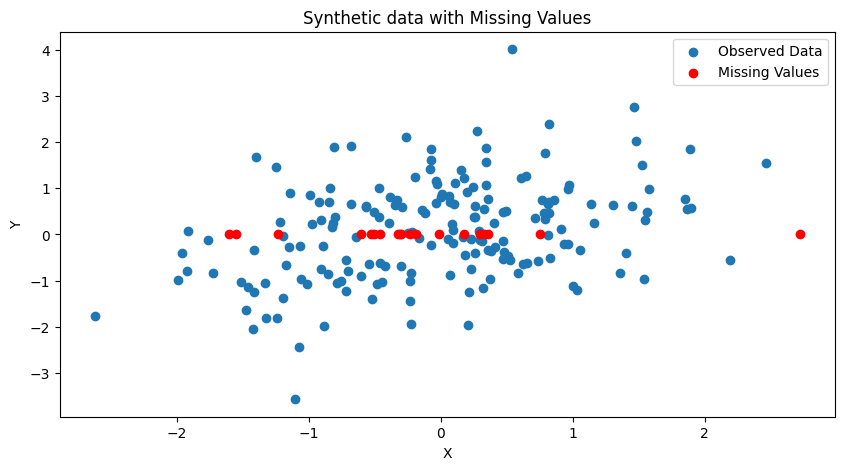

In [44]:
# Set parameters
n_samples = 200
correlation = 0.3
missing_rate = 0.1

# Generate correlated X and Y
X = np.random.normal(0, 1, n_samples)
Y_true = correlation * X + np.random.normal(0, 1, n_samples)

# Missing data
missing_indices = np.random.choice(n_samples, int(n_samples * missing_rate), replace=False)
Y_missing = Y_true.copy()
Y_missing[missing_indices] = np.nan

# Plot original data
plt.figure(figsize=(10, 5))
plt.scatter(X, Y_missing, label='Observed Data')
plt.scatter(X[missing_indices], [0] * len(missing_indices), 
           color='red', label='Missing Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic data with Missing Values')
plt.legend()
plt.show()

In [45]:
class EMImputer:
    def __init__(self, max_iter=100, tol=1e-6):
        self.max_iter = max_iter
        self.tol = tol
        self.log_likelihood = []
        
    def _em_step(self, X, Y):
        # E-step: estimate missing values
        mean_y = np.mean(Y)
        std_y = np.std(Y)
        correlation = np.corrcoef(X, Y)[0, 1]
        
        # Update missing values using regression
        beta = correlation * std_y / np.std(X)
        Y[self.missing_mask] = mean_y + beta * (X[self.missing_mask] - np.mean(X))
        
        # Calculate log-likelihood (only for observed values)
        # We only consider non-missing values in likelihood calculation
        observed_mask = ~self.missing_mask
        ll = np.sum(-0.5 * np.log(2 * np.pi * std_y ** 2) - 
                    ((Y[observed_mask] - mean_y) ** 2) / (2 * std_y ** 2))
        
        return Y, mean_y, std_y, correlation, ll
    
    def fit_transform(self, X, Y):
        self.missing_mask = np.isnan(Y)
        Y_imputed = Y.copy()
        
        # Initialize missing values
        Y_imputed[self.missing_mask] = np.mean(Y_imputed[~self.missing_mask])
        
        # Initialize previous parameters
        prev_ll = float('-inf')
        
        # EM iterations
        for i in range(self.max_iter):
            Y_imputed, mean_y, std_y, correlation, ll = self._em_step(X, Y_imputed)
            self.log_likelihood.append(ll)
            
            print(f"Iteration {i+1}: Mean = {mean_y:.4f}, "
                  f"Std = {std_y:.4f}, Correlation = {correlation:.4f}, "
                  f"Log-likelihood = {ll:.4f}")
            
            # Check convergence using log-likelihood
            if abs(ll - prev_ll) < self.tol:
                print(f"\nConverged after {i+1} iterations!")
                break
                
            # Update previous log-likelihood
            prev_ll = ll
        
        return Y_imputed

In [46]:
imputer = EMImputer(max_iter=100)
Y_imputed = imputer.fit_transform(X, Y_missing)

Iteration 1: Mean = 0.0883, Std = 1.0173, Correlation = 0.3400, Log-likelihood = -268.5014
Iteration 2: Mean = 0.0844, Std = 1.0228, Correlation = 0.3700, Log-likelihood = -268.4007
Iteration 3: Mean = 0.0836, Std = 1.0239, Correlation = 0.3726, Log-likelihood = -268.3824
Iteration 4: Mean = 0.0835, Std = 1.0240, Correlation = 0.3728, Log-likelihood = -268.3806
Iteration 5: Mean = 0.0835, Std = 1.0240, Correlation = 0.3729, Log-likelihood = -268.3804
Iteration 6: Mean = 0.0835, Std = 1.0240, Correlation = 0.3729, Log-likelihood = -268.3804
Iteration 7: Mean = 0.0835, Std = 1.0240, Correlation = 0.3729, Log-likelihood = -268.3804
Iteration 8: Mean = 0.0835, Std = 1.0240, Correlation = 0.3729, Log-likelihood = -268.3804

Converged after 8 iterations!


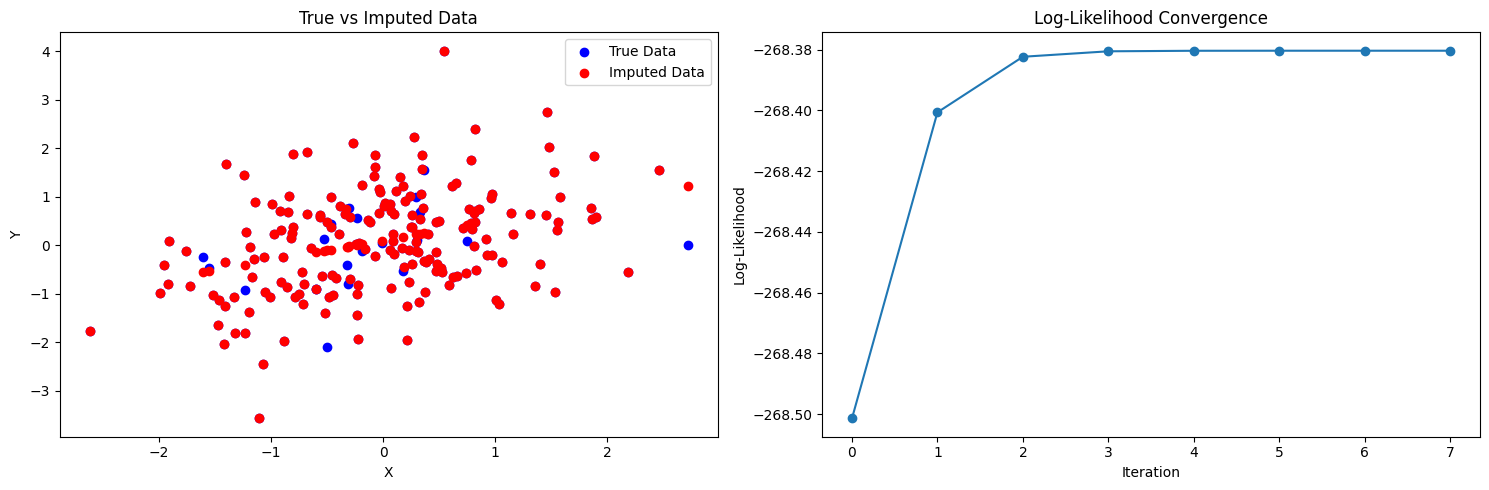


Comparison of true vs imputed values:
First few true values: [-0.11522305 -0.80043318  0.4318652   0.00775246  0.98843596]
First few imputed values: [ 0.02391295 -0.02688755 -0.09029096  1.21867992  0.22200241]

Mean Squared Error: 0.5784


In [48]:
def plot_results(X, Y_true, Y_missing, Y_imputed, missing_indices, log_likelihood):
    # Plot data comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original vs Imputed
    ax1.scatter(X, Y_true, color='blue', label='True Data')
    ax1.scatter(X, Y_imputed, color='red', label='Imputed Data')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title('True vs Imputed Data')
    ax1.legend()
    
    # Log-likelihood convergence
    ax2.plot(log_likelihood, marker='o')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Log-Likelihood')
    ax2.set_title('Log-Likelihood Convergence')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison metrics
    mse = np.mean((Y_true[missing_indices] - Y_imputed[missing_indices])**2)
    print("\nComparison of true vs imputed values:")
    print("First few true values:", Y_true[missing_indices][:5])
    print("First few imputed values:", Y_imputed[missing_indices][:5])
    print(f"\nMean Squared Error: {mse:.4f}")

# Plot results
plot_results(X, Y_true, Y_missing, Y_imputed, missing_indices, imputer.log_likelihood)